# Lecture 15: Cubic Splines
## CMSE 381 - Spring 2024




In this module we are going to implement cubic splines

In [1]:
# Everyone's favorite standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time


# ML imports we've used previously
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression



# Loading in the data

We're going to use the `Wage` data used in the book, so note that many of your plots can be checked by looking at figures in the book.

In [2]:
df = pd.read_csv('../../DataSets/Wage.csv', index_col =0 )
df.head()

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 231655 to 453557
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        3000 non-null   int64  
 1   age         3000 non-null   int64  
 2   sex         3000 non-null   object 
 3   maritl      3000 non-null   object 
 4   race        3000 non-null   object 
 5   education   3000 non-null   object 
 6   region      3000 non-null   object 
 7   jobclass    3000 non-null   object 
 8   health      3000 non-null   object 
 9   health_ins  3000 non-null   object 
 10  logwage     3000 non-null   float64
 11  wage        3000 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 304.7+ KB


In [4]:
df.describe()

,year,age,logwage,wage
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,2005.791000,42.414667,4.653905,111.703608
std,2.026167,11.542406,0.351753,41.728595
min,2003.000000,18.000000,3.000000,20.085537
25%,2004.000000,33.750000,4.447158,85.383940
50%,2006.000000,42.000000,4.653213,104.921507
75%,2008.000000,51.000000,4.857332,128.680488
max,2009.000000,80.000000,5.763128,318.342430


Here's the plot we used multiple times in class to look at a single variable:  `age` vs `wage`

Text(0, 0.5, 'Wage')

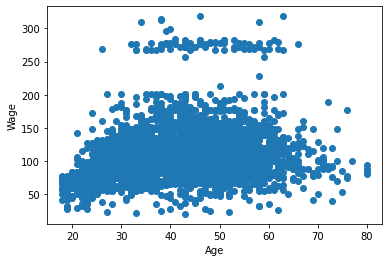

In [5]:
plt.scatter(df.age,df.wage)
plt.xlabel('Age')
plt.ylabel('Wage')

# 1. Splines 

Before we get to the `wage` dataset, we'll build some simpler spline models. Let's start by playing with some toy data, making heavy use of the examples provided on the [scikitlearn spline page](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html).

In [6]:
# Note: this bit is going to use some packages that are newly 
# provided in sklearn 1.0.  If you're having issues, try uncommenting
# and running the update line below.
# %pip install --upgrade scikit-learn

In [7]:
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline

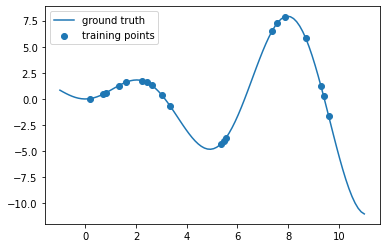

In [8]:
# This code block is going to make us some nasty fake data 
# to try to find some sort of interpolation. 

def f(x):
    """Function to be approximated by polynomial interpolation."""
    return x * np.sin(x)


# whole range we want to plot
x_plot = np.linspace(-1, 11, 100)
y_plot = f(x_plot)


# Make some data.  Provide a small amount of points to make 
# our polynomials all kinds of wiggly.
X = np.linspace(0, 10, 100)
rng = np.random.RandomState(0)
X = np.sort(rng.choice(X, size=20, replace=False))
y = f(X)

# # create 2D-array versions of these arrays to feed to transformers
# X_train = x_train[:, np.newaxis]
# X = X[:, np.newaxis]

X = X.reshape(-1,1)
y = y.reshape(-1,1)


#====ploting======

# plot function
plt.plot(x_plot, y_plot,label="ground truth")

# plot training points
plt.scatter(X, y, label="training points")

plt.legend()

Let's pretend you never saw that $f$ function I used to build the data, you're just handed these scattered data points and asked to learn a piecewise polynomial that fits it. 

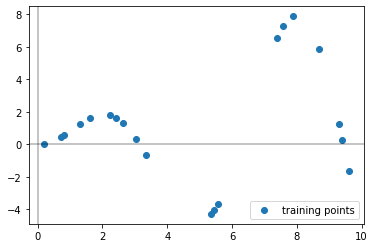

In [9]:
# plot training points
plt.scatter(X, y, label="training points")

# Plots the axes
plt.axhline(0, color="black", alpha=0.3)
plt.axvline(0, color="black", alpha=0.3)

plt.legend()

The `SplineTransformer` sets up our basis functions for us. These are the functions that we are learning coefficients for when we are doing regression.

The knots:
[-9.19191919 -6.06060606 -2.92929293  0.2020202   3.33333333  6.46464646
  9.5959596  12.72727273 15.85858586 18.98989899]


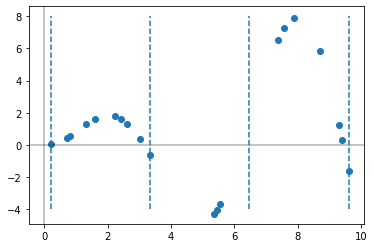

In [10]:
# This sets up the spline transformer. The fit command is deciding where to put the knots
splt = SplineTransformer(n_knots=4, degree=3).fit(X)

print('The knots:')
print(splt.bsplines_[0].t)


#----Visualizing the knots-----#
# Plots the axes
plt.axhline(0, color="black", alpha=0.3)
plt.axvline(0, color="black", alpha=0.3)
# plots the original points
plt.scatter(X, y, label="training points")
# Marks where the knots are as vertical lines
knots = splt.bsplines_[0].t
plt.vlines(knots[3:-3], ymin=-4, ymax=8, linestyles="dashed")

# Uncomment below if you want to see ALL the knots, see note below.
# plt.vlines(knots, ymin=-4, ymax=8, linestyles="dashed")

Note that I am only drawing the middle 4 knots here. The `SplineTransformer` actually hands back several extra knots on either side of the input data points for technical reasons. 

Next, we can peek at the basis function's its using based on the chosen knots. Note that we haven't actually learned any coefficients for the functions yet, we're just setting up what the functions are.

**Warning**: The `sklearn` code uses a different collection of basis functions to get cubic splines. For our purposes, it doesn't matter. We just need this thing to pop out a smooth function which it will do (at least inside the middle 4 knots)

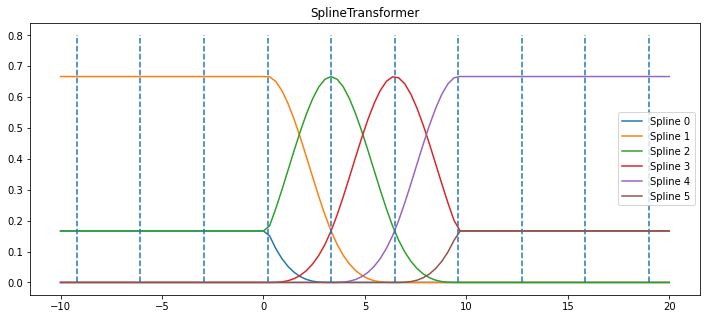

In [11]:
x_plot = np.linspace(-10, 20, 100)

plt.figure(figsize=(12,5))
ax = plt.gca()

ax.plot(x_plot, splt.transform(x_plot.reshape(-1,1)))
ax.legend(ax.lines, [f"Spline {n}" for n in range(6)])
ax.set_title("SplineTransformer")

# plot knots of spline
knots = splt.bsplines_[0].t
ax.vlines(knots, ymin=0, ymax=0.8, linestyles="dashed")

I'm going to make use of a nice function from scikitlearn that builds up a pipeline for us to use.  Basically, the `make_pipline` function here takes your input data, runs the `SplineTransformer` on it to get the features, then runs linear regression.  

In [12]:
# B-spline with 4 + 3 - 1 = 6 basis functions
model = make_pipeline(SplineTransformer(n_knots=4, degree=3), LinearRegression())
model.fit(X, y)

Pipeline(steps=[('splinetransformer', SplineTransformer(n_knots=4)),
                ('linearregression', LinearRegression())])

Now, I can see the coefficients that linear regression learned by digging into the `make_pipeline` object as follows.

In [13]:
model.named_steps['linearregression'].intercept_

array([-21.99825867])

In [14]:
model.named_steps['linearregression'].coef_

array([[  -0.48385244,   26.71804256,   22.23314294,   13.06209193,
          53.89499213, -115.42441711]])

Similarly, I can find the knots as follows.

In [15]:
# Marks where the knots are as vertical lines
knots = model.named_steps['splinetransformer'].bsplines_[0].t
print(knots)


[-9.19191919 -6.06060606 -2.92929293  0.2020202   3.33333333  6.46464646
  9.5959596  12.72727273 15.85858586 18.98989899]


So each of the coefficients were learned for each of the spline functions drawn in the figure above.  While we could try to determine the function by hand, that's getting beyond messy.  However, as usual, we can figure out the predicted values from the learned model on the original $X$ input data as follows.

In [16]:
y_hat = model.predict(X)

We can also draw the full function below by using the predict function on evenly spaced $t$ values. 

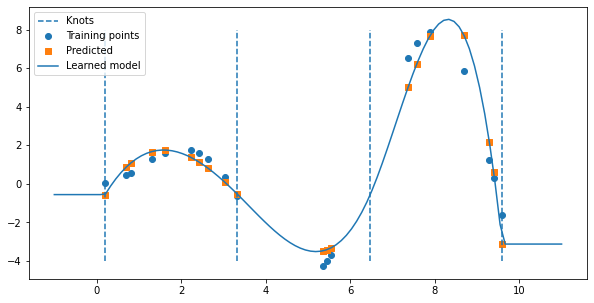

In [17]:
# Make the figure drawn wide
plt.figure(figsize = (10,5))

# Draw knots 
plt.vlines(knots[3:-3], ymin=-4, ymax=8, linestyles="dashed", label = 'Knots')

# plot training points
plt.scatter(X, y, label="Training points")

# Plot predicted values for each X
plt.scatter(X,y_hat,label = 'Predicted',marker = 's')


# Plot the full model
x_plot = np.linspace(-1, 11, 100)
spline_y_plot = model.predict(x_plot.reshape(-1,1))
plt.plot(x_plot,spline_y_plot, label = 'Learned model')

plt.legend()

# 2. Cubic spline on `wage` to predict `age`

&#9989; **<font color=red>Do this:</font>** 
- Split the `wage` and `age` data into a train test split. 
- Using the code above that generates splines, build a cubic spline model to predict wage from age in the `Wage` data set and train on your training set. 
- Use the trained model to predict on your testing set. What is the MSE? 
- Use your trained model to draw the learned spline on the scatter plot of age and wage, as in the left side of Fig 7.5. (*Note we're only doing regular splines with this code, not natural as in Fig 7.4, but the results end up pretty similar in our case*)


In [23]:
# Your code here #
y = df.iloc[:, -1]
X = df.iloc[:,1]



,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154




-----
### Congratulations, we're done!
Written by Dr. Liz Munch, Michigan State University

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.